<a href="https://colab.research.google.com/github/dehlong/playinaround/blob/main/Vit_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install transformers datasets

In [ ]:
import datasets
import transformers
import torch

In [ ]:
data = datasets.load_dataset("samokosik/clothes")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4283 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/756 [00:00<?, ? examples/s]

In [ ]:
ex = data["train"][400]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=534x400>,
 'label': 5}

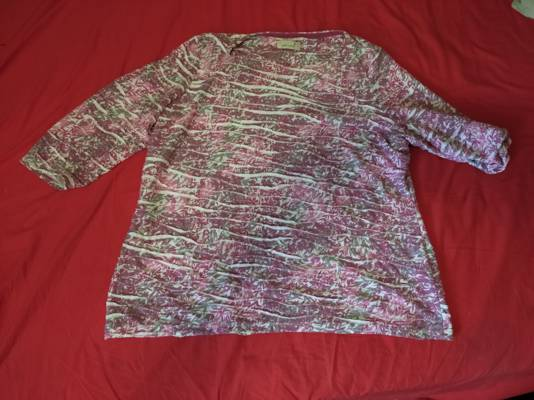

In [ ]:
 image = ex["image"]
 image

In [ ]:
labels = data["train"].features["label"]
labels

NameError: name 'data' is not defined

In [ ]:
metric = datasets.load_metric("accuracy")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4283
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 756
    })
})

In [ ]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
  label2id[label] = i
  id2label[i] = label

In [ ]:
from transformers import ViTFeatureExtractor
model_name_or_path = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size["height"]),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(feature_extractor.size["height"]),
            CenterCrop(feature_extractor.size["height"]),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


In [ ]:
train_ds = data["train"]
val_ds = data["test"]

In [ ]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [ ]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x533>,
 'label': 6,
 'pixel_values': tensor([[[-0.4275, -0.4275, -0.4431,  ...,  0.4980,  0.4824,  0.4510],
          [-0.4667, -0.4667, -0.4353,  ...,  0.4824,  0.4667,  0.4353],
          [-0.5294, -0.5373, -0.5216,  ...,  0.4902,  0.4745,  0.4510],
          ...,
          [-0.2235, -0.2235, -0.2157,  ...,  0.0039,  0.0745,  0.2314],
          [-0.3412, -0.3098, -0.3176,  ..., -0.0118,  0.0275,  0.1137],
          [-0.3725, -0.3412, -0.3490,  ..., -0.0118, -0.0196,  0.0667]],
 
         [[-0.4667, -0.4745, -0.4902,  ...,  0.4745,  0.4588,  0.4275],
          [-0.5059, -0.5137, -0.4824,  ...,  0.4588,  0.4431,  0.4118],
          [-0.5765, -0.5843, -0.5686,  ...,  0.4667,  0.4510,  0.4275],
          ...,
          [-0.2627, -0.2627, -0.2549,  ..., -0.0039,  0.0667,  0.2314],
          [-0.3804, -0.3490, -0.3569,  ..., -0.0275,  0.0196,  0.1137],
          [-0.4118, -0.3882, -0.3961,  ..., -0.0118, -0.0196,  0.0667]]

In [ ]:
from transformers import ViTForImageClassification
model_name_or_path = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    'finetuned-clothes',
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  hub_strategy="end"
)

RuntimeError: Failed to import transformers.training_args because of the following error (look up to see its traceback):
cannot import name 'torch_required' from 'transformers.utils' (/usr/local/lib/python3.10/dist-packages/transformers/utils/__init__.py)

In [ ]:
!pip install transformers==4.27.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 37.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.23.1
    Uninstalling transformers-4.23.1:
      Successfully uninstalled transformers-4.23.1
